<a href="https://colab.research.google.com/github/mehdiz5/Forcasting-inflation-/blob/main/forecasting_inflation_with_arima_and_lstm_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Import Libraries et Data Loading
<a id="libraries"></a>

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

np.random.seed(234)
tf.random.set_seed(234)

In [ ]:
print(tf.__version__)

2.6.2


In [ ]:
monthly_raw = pd.read_csv('../input/usa-key-macroeconomic-indicators/macro_monthly.csv',parse_dates=True)
monthly_raw.shape

(490, 12)

Prenons à partir de 1994, car il y a quelques NaNs pour certains indicateurs.
Nous pouvons le faire en éliminant simplement les NaNs.

In [ ]:
monthly_raw.dropna(inplace=True)
monthly_raw.head(5)

,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
156,1994-01-01,6.6,7.1,3481.800,7363.1,4585.1,105.21,5.750500,3.050645,513314.0,67.0596,154.5
157,1994-02-01,6.6,6.5,3459.675,7377.2,4632.6,104.66,5.973158,3.245000,513196.0,67.1060,154.8
158,1994-03-01,6.5,6.8,3476.975,7401.7,4646.0,104.78,6.482609,3.335806,521040.0,67.7792,155.3
159,1994-04-01,6.4,6.4,3507.150,7402.0,4671.1,104.68,6.972105,3.555000,528063.0,68.1906,155.5
160,1994-05-01,6.1,7.6,3472.840,7487.4,4669.5,103.78,7.183333,4.010968,532328.0,68.5136,155.9


## Compréhension des données
Vérification rapide des types de données et conversion de realtime_start et date en datetime.

In [ ]:
monthly_raw.dtypes

monthly_raw.DATE = pd.to_datetime(monthly_raw.DATE)

DATE       object
unrate    float64
psr       float64
m2        float64
dspic     float64
pce       float64
reer      float64
ir        float64
ffer      float64
tcs       float64
indpro    float64
ccpi      float64
dtype: object

In [ ]:
monthly_raw['DATE'].nunique()

334

In [ ]:
monthly_df = monthly_raw.copy()

### Tendance des indicateurs macroéconomiques
<a id = "trend"></a>
Nous pouvons commencer par générer des caractéristiques et créer des variations en pourcentage d'un mois à l'autre et d'une année à l'autre.

array([[<AxesSubplot:title={'center':'Unemployment Rate'}>,
        <AxesSubplot:title={'center':'Personal Saving Rate'}>,
        <AxesSubplot:title={'center':'M2'}>],
       [<AxesSubplot:title={'center':'Disposable Income'}>,
        <AxesSubplot:title={'center':'Personal Consumption Expenditure'}>,
        <AxesSubplot:title={'center':'Real Effective Exchange Rate'}>],
       [<AxesSubplot:title={'center':'10Y Treasury Yield'}>,
        <AxesSubplot:title={'center':'Fed Rate'}>,
        <AxesSubplot:title={'center':'Construction Spending'}>],
       [<AxesSubplot:title={'center':'Industrial Production Index'}>,
        <AxesSubplot:title={'center':'Core CPI'}>,
        <AxesSubplot:title={'center':'Core CPI % Change MoM'}>]],
      dtype=object)

Text(0.5, 0.98, '27 Year Macroeconomic Indicators for the United States')

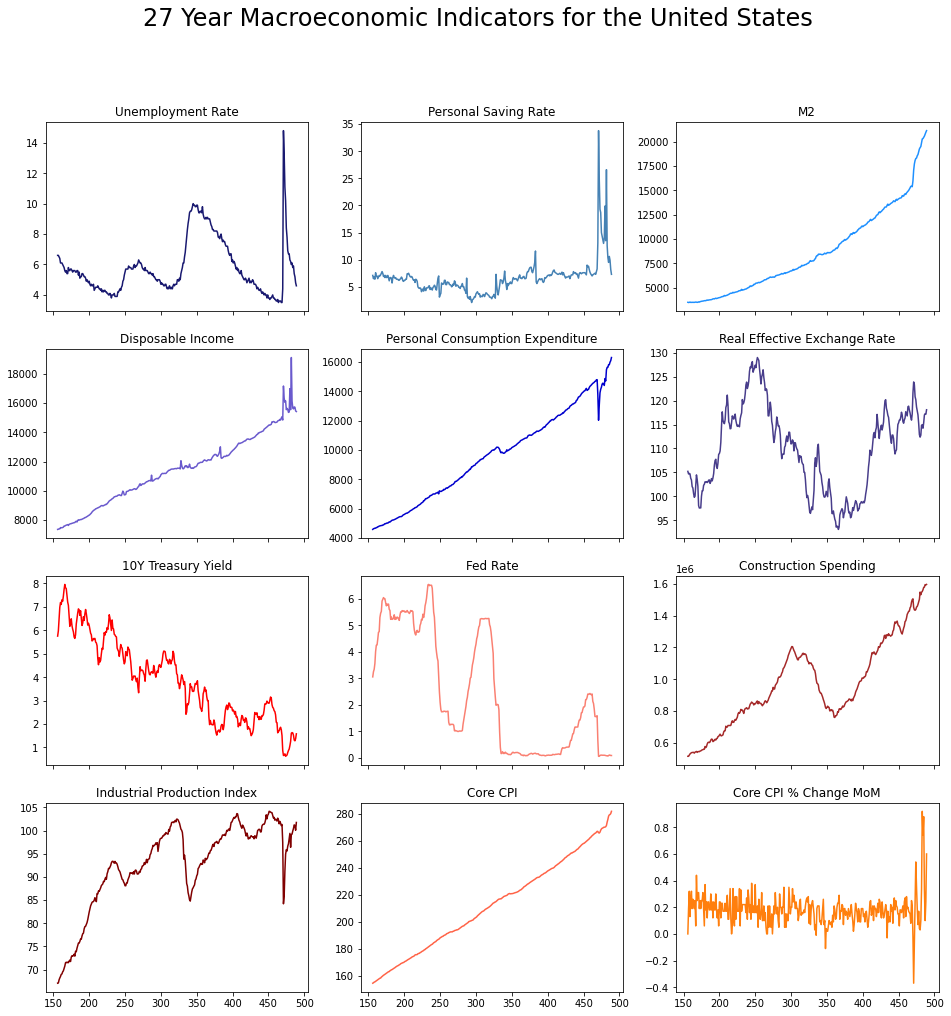

In [ ]:
monthly_df['cpi_pct_mom'] = round((monthly_df['ccpi'].pct_change().fillna(0))*100,2)
monthly_df['cpi_pct_yoy'] = round((monthly_df['ccpi'].pct_change(12).fillna(0))*100,2)

monthly_df.iloc[:, 1:13].plot(kind ='line',
            subplots = True,
            figsize = (16,16),
            title = ['Unemployment Rate', 'Personal Saving Rate','M2','Disposable Income','Personal Consumption Expenditure','Real Effective Exchange Rate',
                     '10Y Treasury Yield','Fed Rate','Construction Spending','Industrial Production Index','Core CPI','Core CPI % Change MoM'],
            legend = False,
            layout = (4,3),
            sharex = True,
            style = ['midnightblue', 'steelblue', 'dodgerblue', 'slateblue','mediumblue','darkslateblue','red','salmon','brown','maroon','tomato'])

plt.suptitle('27 Year Macroeconomic Indicators for the United States', fontsize = 24)

### Tendance de l'IPC de base par mois et par trimestre
<a id = "mq"></a>

In [ ]:
monthly_df['year'] = monthly_df['DATE'].apply(lambda x: x.year)
monthly_df['quarter'] = monthly_df['DATE'].apply(lambda x: x.quarter)
monthly_df['month'] = monthly_df['DATE'].apply(lambda x: x.month)

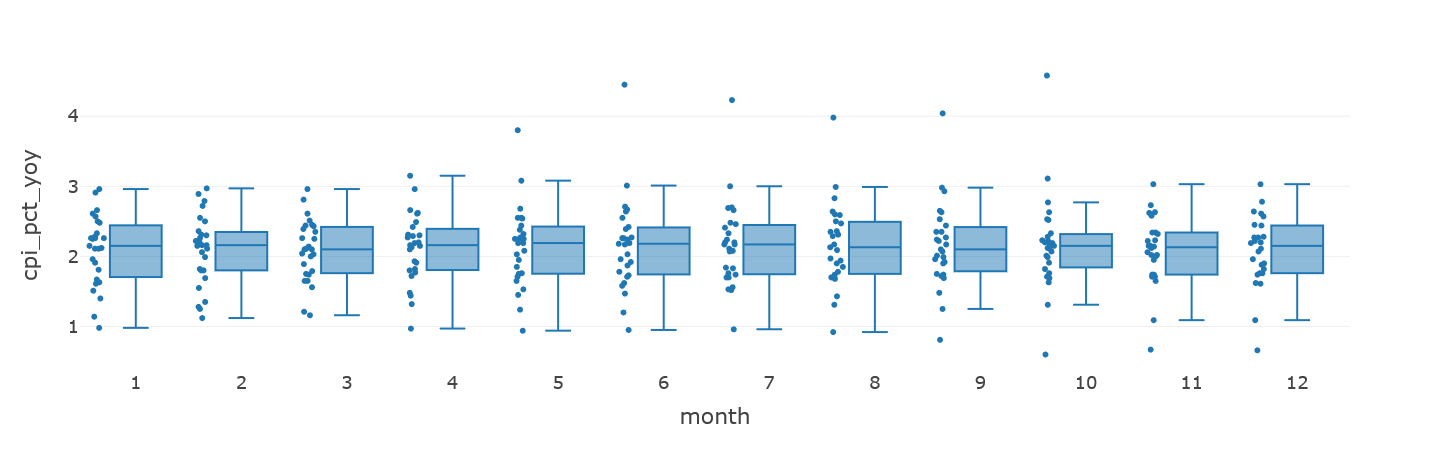

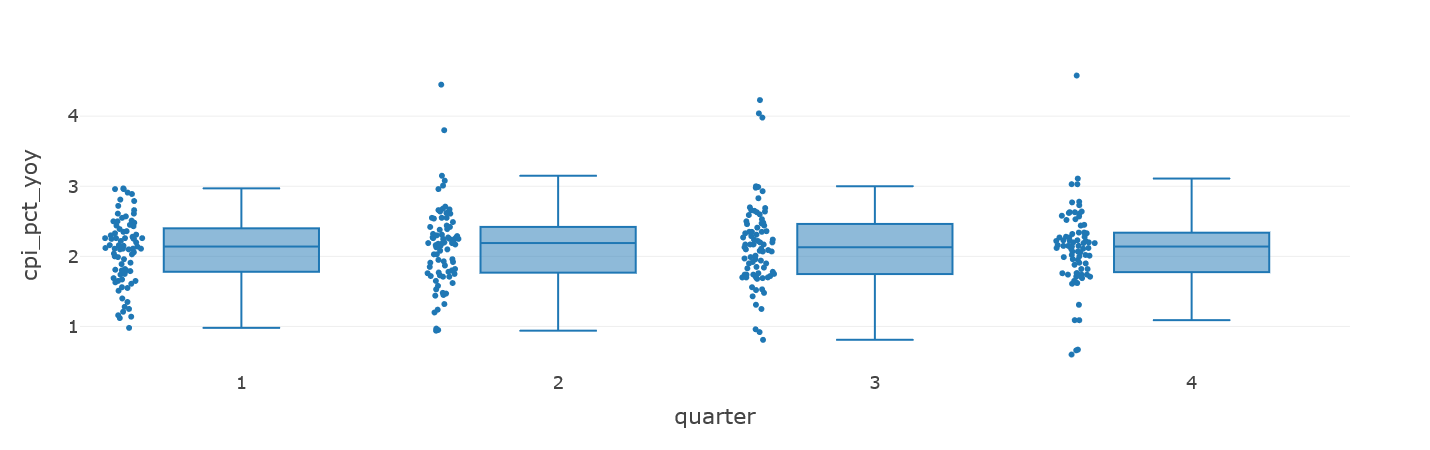

In [ ]:
fig = px.box(monthly_df[12:], x="month", y="cpi_pct_yoy", points = "all", template = "presentation",)
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',))

fig = px.box(monthly_df[12:], x="quarter", y="cpi_pct_yoy", points = "all", template = "presentation")

fig.show()

Si l'on examine la variation de l'IPC de base sur une base annualisée, on constate que les premières parties de l'année ont connu des augmentations plus importantes de l'IPC de base. Au cours des derniers mois, il y a plus de valeurs aberrantes (sous les moustaches inférieures), ce qui signifie qu'il y a eu peu de changement par rapport à l'année précédente. Nous pouvons explorer davantage la volatilité de la variation de l'IPC de base en glissement annuel.

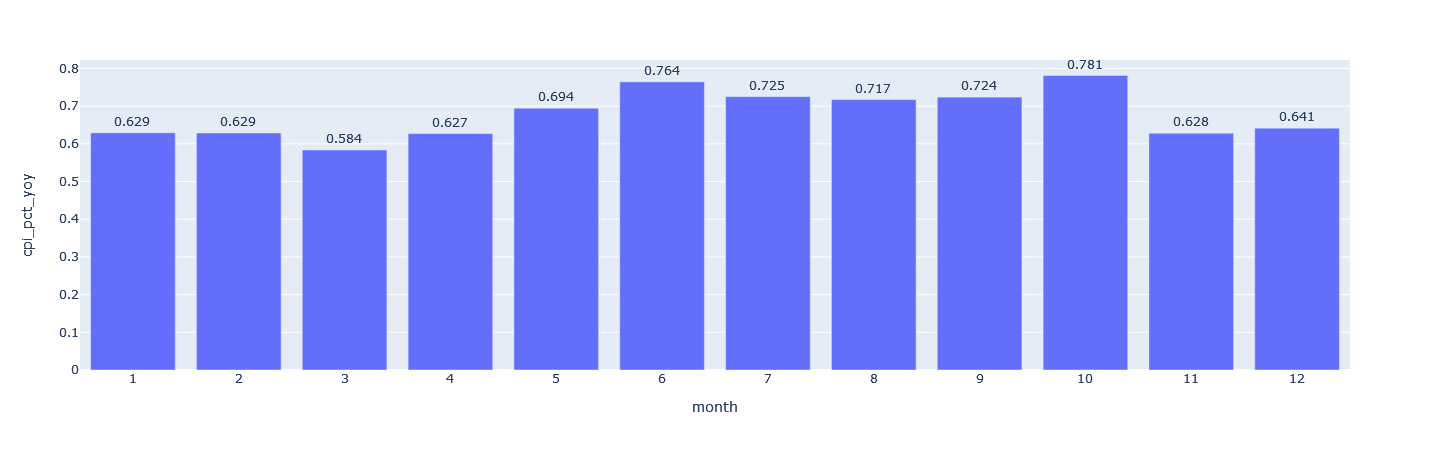

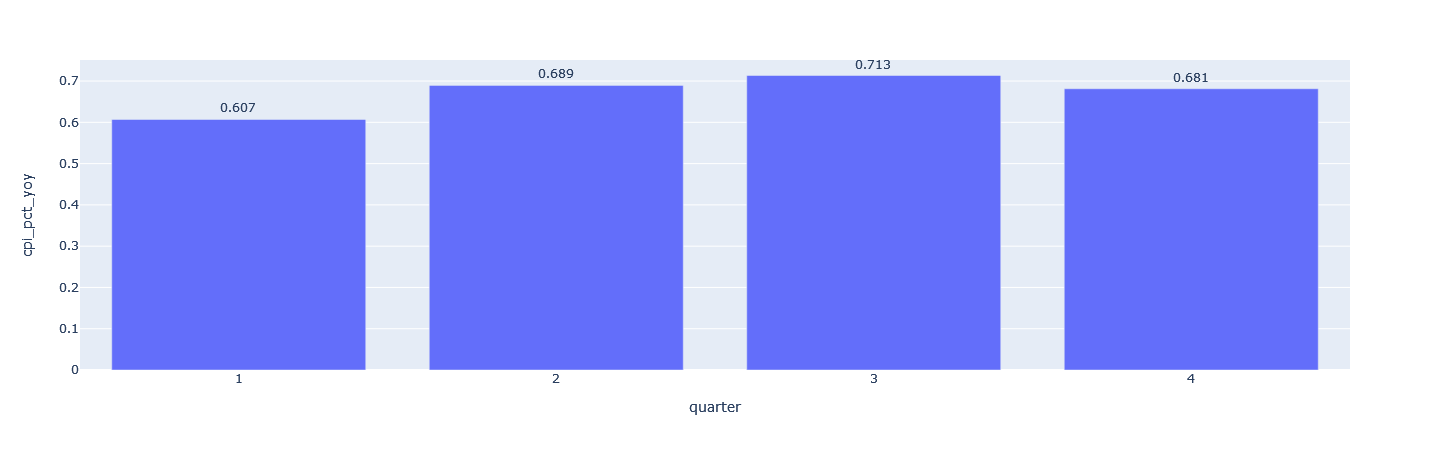

In [ ]:
fig = px.bar(
    data_frame=monthly_df.groupby(['month']).std().reset_index(), 
    x="month", 
    y="cpi_pct_yoy", text="cpi_pct_yoy"
).update_traces(texttemplate='%{text:0.3f}', textposition='outside').update_xaxes(nticks=13)
fig.show()

fig = px.bar(
    data_frame=monthly_df.groupby(['quarter']).std().reset_index(), 
    x="quarter", 
    y="cpi_pct_yoy", text="cpi_pct_yoy").update_traces(texttemplate='%{text:0.3f}', textposition='outside').update_xaxes(nticks=5)
fig.show()

## Prévision de l'inflation

In [ ]:
monthly_raw.shape
monthly_raw.head(5)

(334, 12)

,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
156,1994-01-01,6.6,7.1,3481.800,7363.1,4585.1,105.21,5.750500,3.050645,513314.0,67.0596,154.5
157,1994-02-01,6.6,6.5,3459.675,7377.2,4632.6,104.66,5.973158,3.245000,513196.0,67.1060,154.8
158,1994-03-01,6.5,6.8,3476.975,7401.7,4646.0,104.78,6.482609,3.335806,521040.0,67.7792,155.3
159,1994-04-01,6.4,6.4,3507.150,7402.0,4671.1,104.68,6.972105,3.555000,528063.0,68.1906,155.5
160,1994-05-01,6.1,7.6,3472.840,7487.4,4669.5,103.78,7.183333,4.010968,532328.0,68.5136,155.9


Set date as the dataframe's index.

In [ ]:
df_cpi = monthly_raw.set_index('DATE')

## ARIMA Implementation
Comme il s'agit de prévoir des séries chronologiques, le modèle ARIMA (Autoregressive Integrated Moving Average), qui combine les modèles AR et MA, peut être utilisé pour prévoir les tendances/valeurs futures. Parmi les avantages de l'utilisation de l'ARIMA, on peut citer sa facilité d'interprétation, sa facilité de mise en œuvre et le fait qu'il peut même fonctionner mieux pour des séries relativement courtes, comme dans le cas présent, où le nombre d'observations n'est pas suffisant pour appliquer des modèles plus sophistiqués.

<AxesSubplot:xlabel='DATE'>

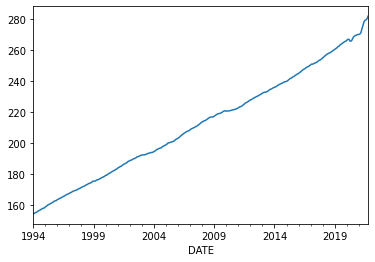

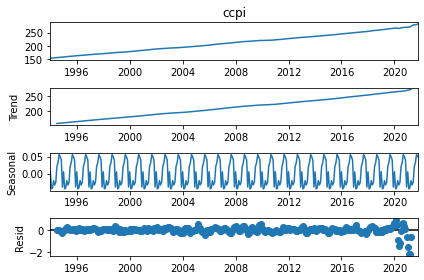

In [ ]:
df_cpi['ccpi'].plot()
fig = seasonal_decompose(df_cpi['ccpi'], model='additive').plot()

Les données montrent une nette tendance à la hausse et ne sont pas stationnaires. Comme l'une des principales hypothèses du modèle ARIMA est que la série chronologique est stationnaire, nous devons corriger la non-stationnarité ultérieurement.

### Splitting the Data

Training dataset: 322, Test dataset: 12


<AxesSubplot:xlabel='DATE'>

<AxesSubplot:xlabel='DATE'>

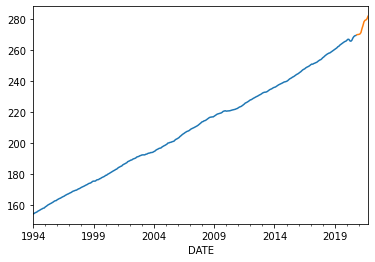

In [ ]:
split_point = len(df_cpi) - 12
train, test = df_cpi[0:split_point], df_cpi[split_point:]
print('Training dataset: %d, Test dataset: %d' % (len(train), len(test)))
train['ccpi'].plot()
test['ccpi'].plot()

Le graphique montre que l'année 2020 a connu une baisse en raison des restrictions liées à la pandémie. La ligne orange indique le jeu de test.

### Prendre les premières différences
Ici, nous trouvons le nombre de différenciations optimales pour éliminer la racine unitaire afin que la série chronologique soit stationnaire. Ceci est fait en utilisant la fonction diff() et en testant avec le test de Dickey-Fuller augmenté.

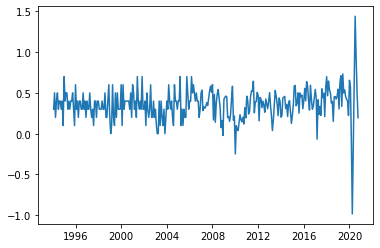

In [ ]:
diff = train['ccpi'].diff()
plt.plot(diff)
plt.show()
diff = diff.dropna()

In [ ]:
def adf_test(df):
    result = adfuller(df.values)
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

adf_test(diff)

Series is stationary


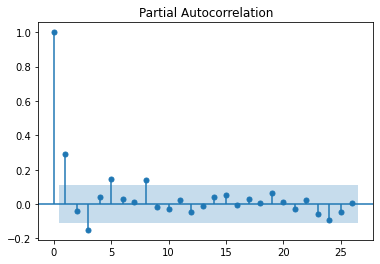

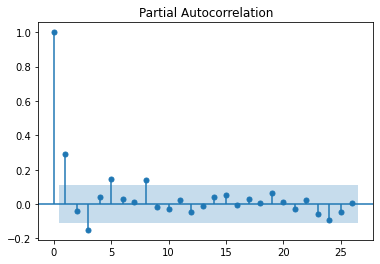

In [ ]:
plot_pacf(diff.values)

Finding the order of Moving Average Term (q)<br>
- q = 1 and 2 is significant, try conservative take of q = 1.

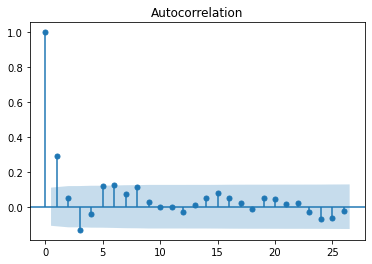

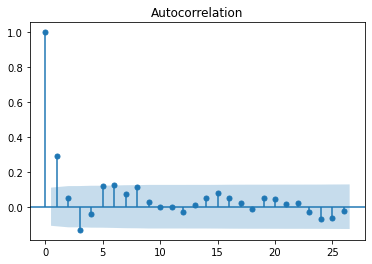

In [ ]:
plot_acf(diff.values)

### Construction du modèle
L'IPC présentant une croissance exponentielle (la variance augmente), nous construisons le modèle sur le ln(IPC), c'est-à-dire en convertissant les valeurs brutes en valeurs logarithmiques.
Comme nous l'avons découvert précédemment, les paramètres du modèle ARIMA seront fixés à 1,1,1.

In [ ]:
arima_model = ARIMA(np.log(train['ccpi']), order = (1,1,1))

arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ccpi   No. Observations:                  322
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1780.484
Date:                Sun, 09 Jan 2022   AIC                          -3554.968
Time:                        06:00:58   BIC                          -3543.654
Sample:                    01-01-1994   HQIC                         -3550.450
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9682      0.016     59.833      0.000       0.937       1.000
ma.L1         -0.5010      0.043    -11.606      0.000      -0.586      -0.416
sigma2      8.851e-07   4.25e-08     20.833      0.000    8.02e-07    9.68e-07
===================================================================================
Ljung-Box (L1) (Q):                   3.44   Jarque-Bera (JB):               180.01
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.27
Prob(H) (two-sided):                  0.84   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Prévisions pour novembre 2020 - octobre 2021

The forecasted U.S. Core Consumer Price Index (CPI) YoY is  1.39


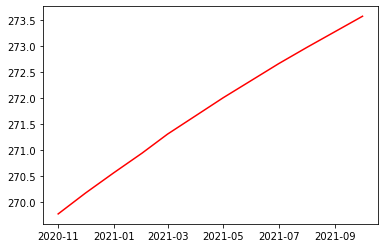

In [ ]:
forecast = arima_fit.forecast(steps=12)
forecast = np.exp(forecast)

plt.plot(forecast, color = 'red')

pct_chg = ((forecast[-1] - df_cpi.iloc[-12]['ccpi'])/df_cpi.iloc[-12]['ccpi']) * 100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is ' , round(pct_chg,2))

### Prévisions pour le 20 novembreEvaluation du modèle ARIMA
- avec RMSE et
- Moyenne de y observé - y prédit

Sur la base de l'erreur moyenne, le modèle ARIMA surestime la valeur de l'IPC de base de 0,25 en moyenne.20 - Octobre 2021

In [ ]:
mse = mean_squared_error(test['ccpi'].values, forecast[:12])
print('MSE: ', mse)
model_error = test['ccpi'] - forecast
print('Mean Model Error: ', model_error.mean())

MSE:  20.43574094104357
Mean Model Error:  3.1464952666371317


### 1-Step Forecast for November 2021

In [ ]:
arima_model = ARIMA(np.log(test['ccpi']), order = (1,1,1),freq=test.index.inferred_freq)

arima_fit = arima_model.fit()

forecast = arima_fit.forecast(steps=1)
forecast = np.exp(forecast)

print('The Core CPI value for the month November 2021 predicted by ARIMA model is', round(forecast[0],2))

The Core CPI value for the month November 2021 predicted by ARIMA model is 283.19


Dans l'ensemble, nous pouvons constater que le modèle ARIMA a donné de mauvais résultats, car l'augmentation a été plus importante au cours des derniers mois de 2021. Nous pouvons améliorer le modèle en incluant d'autres caractéristiques et en utilisant des prévisions multivariées.